# Vision Transformers

### Understanding Self-Attention and Its Role in Vision Tasks

#### What is Self-Attention?
Self-attention is a mechanism that allows a model to focus on different parts of an input sequence (or image) when computing a representation. Initially popularized in natural language processing through the Transformer architecture (Vaswani et al., 2017), self-attention has become a cornerstone in computer vision as well.

#### How Self-Attention Works
Given a set of input features, self-attention computes pairwise interactions between all elements of the input to determine their relevance to one another. These interactions are encoded as weights, which are used to compute a weighted sum of the input features. The core components of self-attention are:
- **Query (Q)**: Encodes the current element we are focusing on.
- **Key (K)**: Encodes elements we compare the query against.
- **Value (V)**: Holds the information we want to propagate.

The attention score is computed as:
$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$
where $d_k$ is the dimensionality of the key.

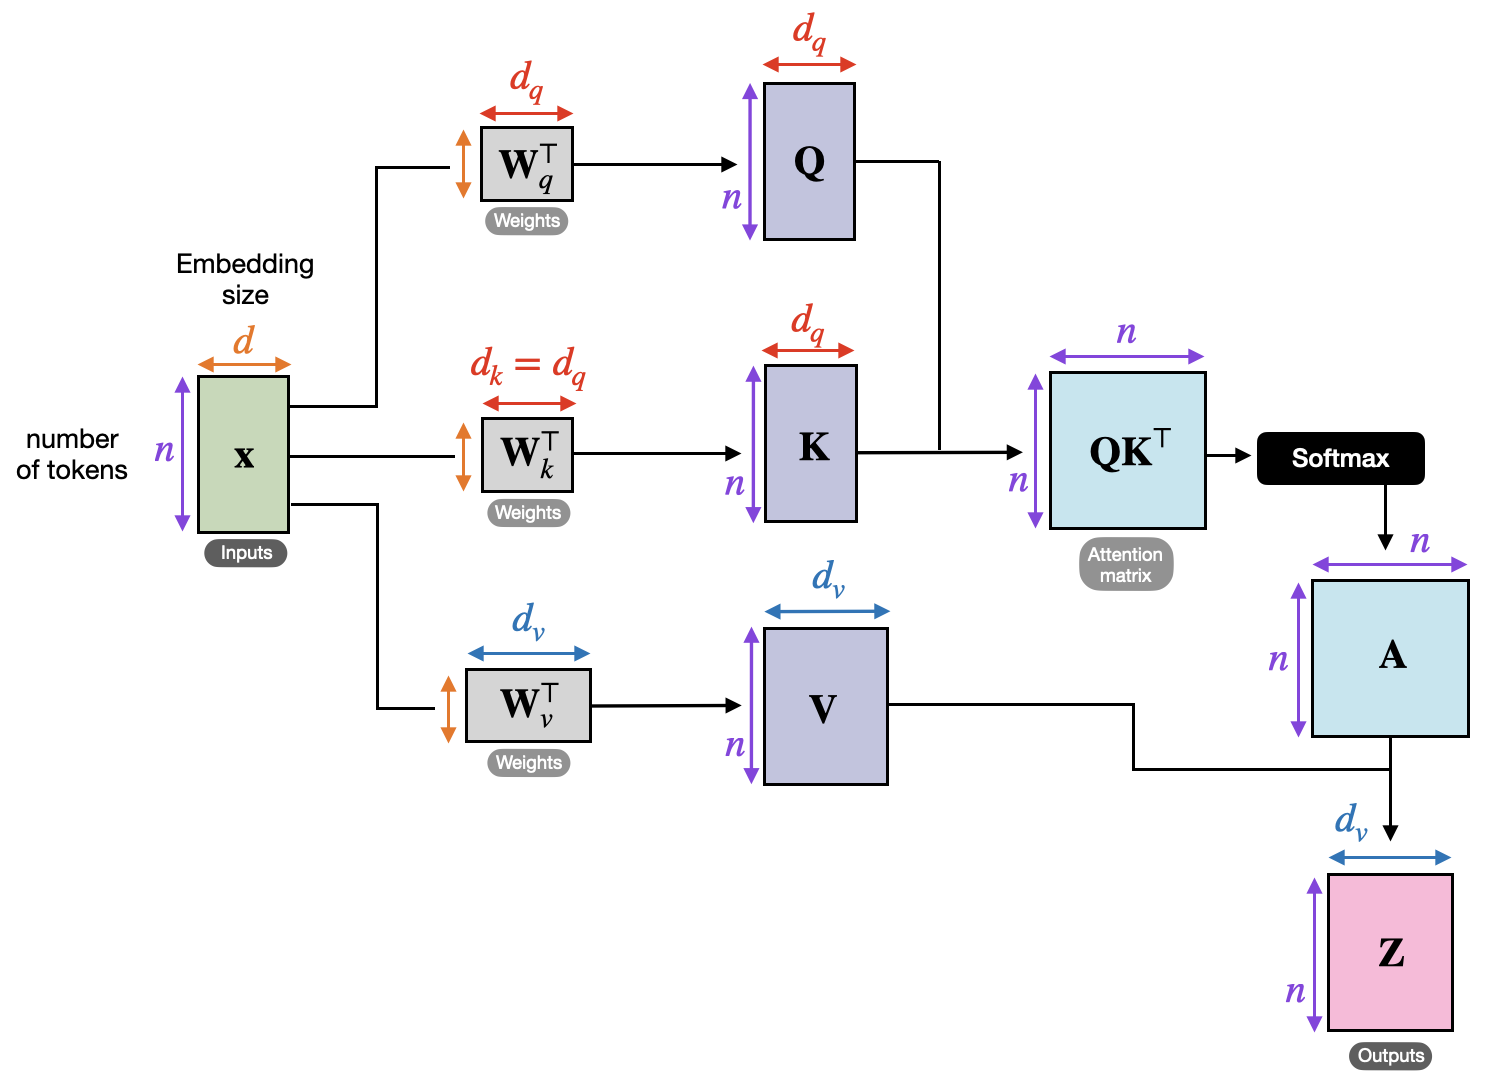

Source: https://www.google.com/url?sa=i&url=https%3A%2F%2Fsebastianraschka.com%2Fblog%2F2023%2Fself-attention-from-scratch.html&psig=AOvVaw1EdjQqFF8Ti9TUFHfUy2UC&ust=1734816890582000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCLClltemt4oDFQAAAAAdAAAAABAE

#### Advantages of Self-Attention in Vision Tasks
1. **Global Context**: Unlike convolutional layers, which have a fixed receptive field, self-attention captures global dependencies in the input.
2. **Dynamic Weighting**: Attention scores dynamically adapt based on the input, making the model highly expressive.
3. **Scalability to Large Inputs**: While computationally intensive, self-attention can be effectively scaled with techniques like sparse attention or patch-wise processing in images.

#### Challenges in Applying Self-Attention to Vision
1. **High Computational Cost**: Computing pairwise interactions scales quadratically with input size.
2. **Loss of Spatial Structure**: Images have a clear 2D spatial layout that self-attention does not natively respect. This is mitigated using **positional encoding**.

---

### Vision Transformers (ViTs)

#### Overview
Vision Transformers (ViTs), introduced by Dosovitskiy et al. (2020) in the paper *"An Image is Worth 16x16 Words"*, are an application of the Transformer architecture to image classification. Instead of convolutions, ViTs rely entirely on self-attention to process image patches.

#### How Vision Transformers Work
1. **Image Patchification**:
   - The input image is divided into fixed-size patches (e.g., 16x16).
   - Each patch is flattened and linearly embedded into a feature vector.

2. **Positional Encoding**:
   - Since the Transformer architecture does not account for spatial relationships, positional encodings are added to the patch embeddings.

3. **Transformer Layers**:
   - A stack of self-attention layers processes the embeddings, learning global dependencies.

4. **Classification Head**:
   - A special [CLS] token is prepended to the patch embeddings, and its final representation is used for classification.

#### Advantages of Vision Transformers
1. **Scalable Architecture**: ViTs outperform CNNs when trained on large datasets due to their ability to model global dependencies.
2. **Simplicity**: ViTs require fewer inductive biases compared to CNNs.

#### Challenges of Vision Transformers
1. **Data Efficiency**: ViTs require large datasets to achieve optimal performance.
2. **Computational Intensity**: The quadratic complexity of self-attention poses challenges for high-resolution images.

#### Positional Encoding
To retain spatial information, ViTs incorporate positional encodings. These can be either:
- **Learned**: Trainable parameters that adapt during training.
- **Fixed**: Sinusoidal encodings as used in the original Transformer architecture.

$\text{PE}_{(pos, 2i)} = \sin(\frac{pos}{10000^{2i/d}})$

$\text{PE}_{(pos, 2i+1)} = \cos(\frac{pos}{10000^{2i/d}})$

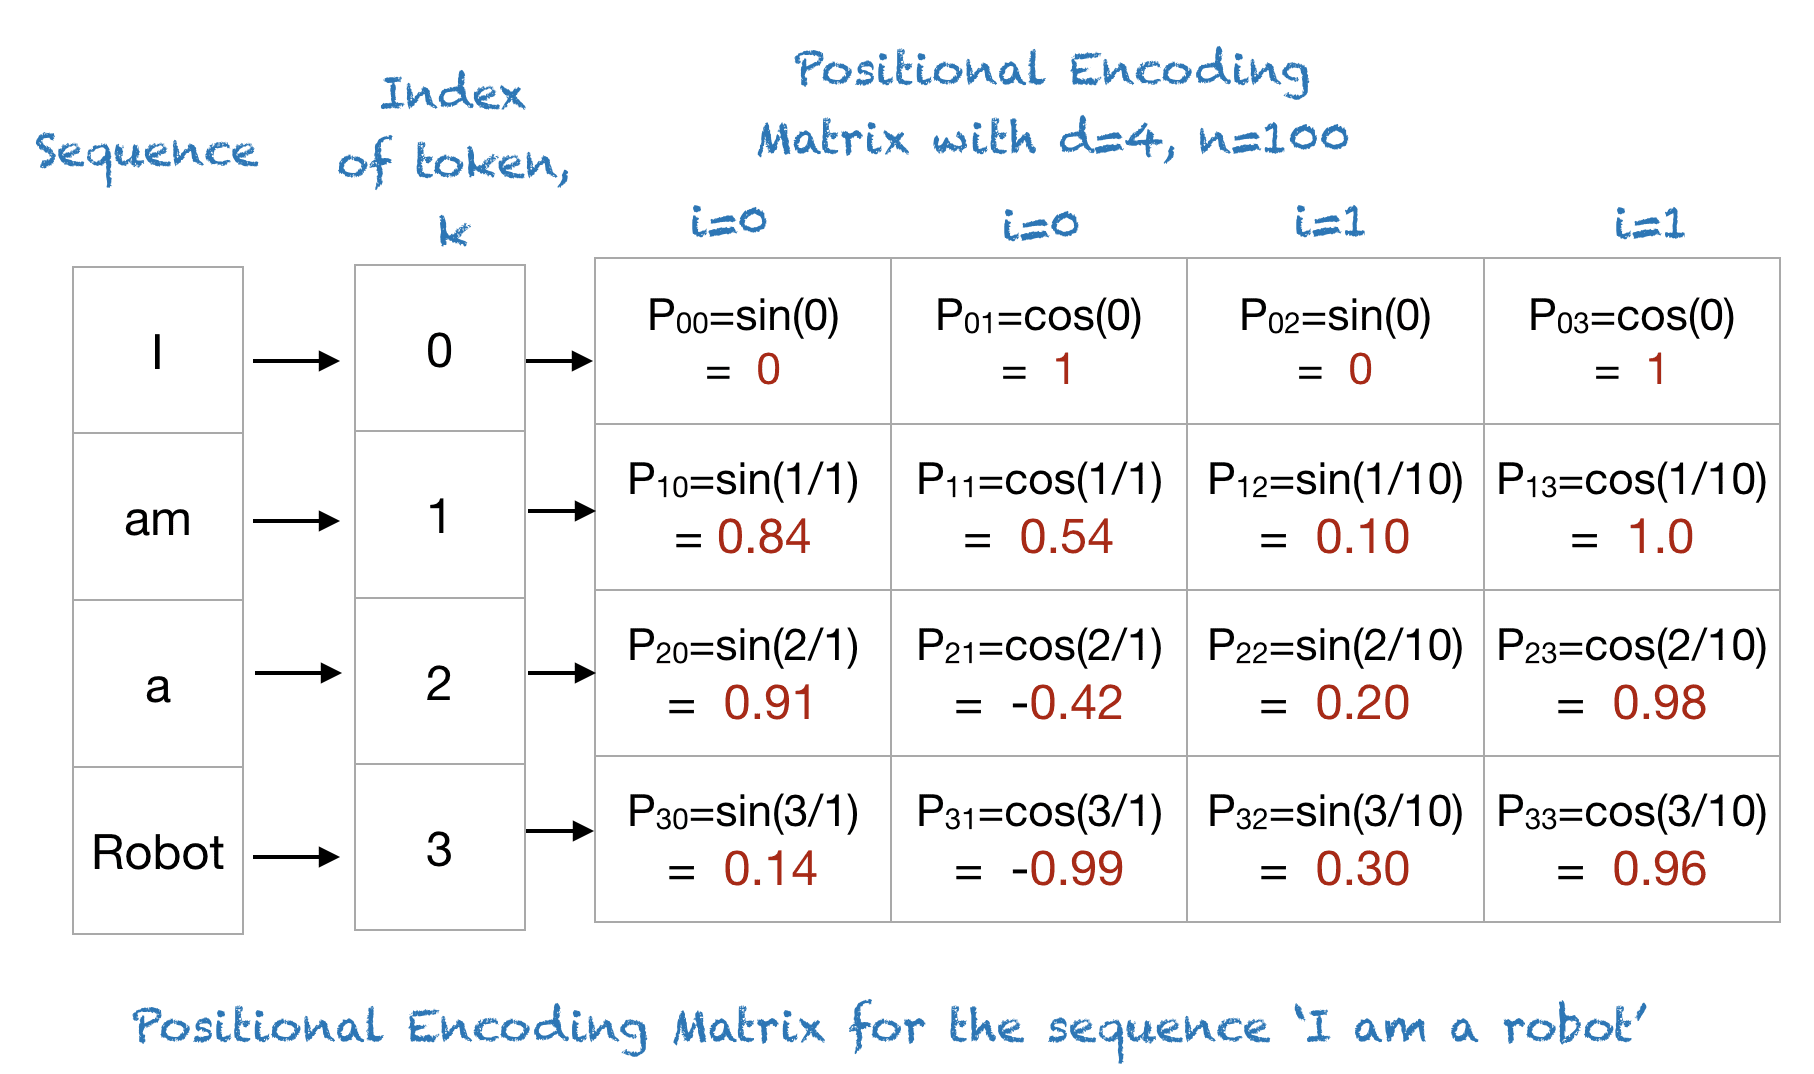

Source: https://www.google.com/url?sa=i&url=https%3A%2F%2Fmachinelearningmastery.com%2Fa-gentle-introduction-to-positional-encoding-in-transformer-models-part-1%2F&psig=AOvVaw2SeYyCtr19EeEFAkyDyoJj&ust=1734816980324000&source=images&cd=vfe&opi=89978449&ved=0CBcQjhxqFwoTCMDf74Gnt4oDFQAAAAAdAAAAABAE

---

Let's explore the process of training and evaluating a vision transformer in this notebook.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

### Preparing the Dataset

#### Dataset Overview:
- CIFAR-10 consists of 60,000 32x32 color images in 10 classes, with 50,000 for training and 10,000 for testing.
- Each image belongs to one of the following categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

#### Data Augmentation:
- `RandomHorizontalFlip`: Adds variability by flipping images horizontally.
- `RandomCrop`: Helps the model generalize by cropping the image randomly.
- `Normalize`: Standardizes pixel values for better convergence.

These transformations enhance the model's ability to generalize to unseen data and prevent overfitting.

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load datasets
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Building the Vision Transformer

We will be building out these components of the vision transformer:

1. **Patch Embedding**:
   - Converts the input image into smaller patches (e.g., 4x4 patches for a 32x32 image).
   - Each patch is flattened and passed through a linear layer to create patch embeddings.

2. **Positional Encoding**:
   - Adds information about the spatial location of patches since self-attention lacks inherent spatial awareness.
   - Positional encodings are either fixed (e.g., sinusoidal) or learned.

3. **Transformer Layers**:
   - A stack of self-attention layers processes the patch embeddings.
   - Each layer computes interactions between all patches, capturing global dependencies.

4. **Classification Head**:
   - A special [CLS] token is prepended to the patch embeddings.
   - The final representation of this token is used for classification.



In [3]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, num_classes=10, dim=64, depth=6, heads=4, mlp_dim=128):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_dim = (patch_size ** 2) * 3
        self.dim = dim

        # Patch embedding
        self.patch_embed = nn.Linear(self.patch_dim, dim)

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(1, self.num_patches + 1, dim))

        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        # Transformer layers
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(dim, heads, mlp_dim, dropout=0.1)
            for _ in range(depth)
        ])

        # Classification head
        self.to_cls_token = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        # Patchify input
        b, c, h, w = x.shape
        x = x.view(b, self.num_patches, -1)  # Flatten patches
        x = self.patch_embed(x)  # Linear projection

        # Add positional encoding
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.positional_encoding

        # Pass through Transformer layers
        for layer in self.layers:
            x = layer(x)

        # Classification
        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)

# Instantiate the model
model = VisionTransformer()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionTransformer(
  (patch_embed): Linear(in_features=48, out_features=64, bias=True)
  (layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (linear1): Linear(in_features=64, out_features=128, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=128, out_features=64, bias=True)
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (to_cls_token): Identity()
  (mlp_head): Sequential(
    (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=64, out_features=10, bias=True)
  )
)

### Training and Evaluation

#### Training Loop:
- The model iterates over the training dataset, computes the loss, and updates its parameters using backpropagation.
- `CrossEntropyLoss` is used as the loss function since CIFAR-10 is a multi-class classification problem.
- The `Adam` optimizer adjusts the model's weights to minimize the loss function.

#### Evaluation:
- After training, the model's accuracy is tested on the unseen test dataset.
- The evaluation loop computes the number of correctly classified images and calculates the overall accuracy.

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

small_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=2, sampler=torch.utils.data.SubsetRandomSampler(range(5000)))
epochs = 2

def train(model, loader, criterion, optimizer, epochs=2):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(loader):.4f}")

train(model, small_train_loader, criterion, optimizer)

# Evaluation
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {100 * correct / total:.2f}%")

evaluate(model, test_loader)

100%|██████████| 79/79 [00:34<00:00,  2.32it/s]


Epoch 1, Loss: 2.3349


100%|██████████| 79/79 [00:33<00:00,  2.39it/s]

Epoch 2, Loss: 2.3141


Accuracy: 10.00%


## Exercises

### 1. Modify the Patch Size
- Change the patch size in the Vision Transformer model from 4x4 to 8x8. Observe how this affects the performance and training time.
- **Hint:** Modify the `patch_size` parameter in the `VisionTransformer` class and ensure that `img_size // patch_size` still produces a valid number of patches.

### 2. Implement Learnable Positional Encoding
- Replace the current randomly initialized positional encoding with a trainable embedding layer. Train the model and compare its performance to the fixed positional encoding.
- **Hint:** Use `nn.Embedding` to create a learnable positional encoding, where the number of embeddings equals the number of patches plus one (for the [CLS] token).

### 3. Add Dropout to Transformer Layers
- Introduce dropout in the Transformer layers to improve regularization. Experiment with different dropout rates and analyze the effect on performance.
- **Hint:** Update the `nn.TransformerEncoderLayer` definition to include a `dropout` parameter (e.g., `dropout=0.2`).

### 4. Experiment with Attention Heads
- Modify the number of attention heads in the multi-head self-attention layers. Compare the performance of models with fewer (e.g., 2) and more (e.g., 8) heads.
- **Hint:** Change the `heads` parameter in the `VisionTransformer` class and ensure that it divides the `dim` parameter evenly.

### 5. Visualize Attention Maps
- Visualize the attention maps generated by the self-attention mechanism for a few sample images. Highlight which parts of the image the model focuses on during classification.
- **Hint:** Extract the attention scores from the Transformer layers and use a heatmap library like `seaborn.heatmap` for visualization.
